The first thing to do is to include all the necessary libraries for our work.

In [ ]:
#importing the necessary libraries
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
!pip install pgmpy
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
from pgmpy.models.BayesianNetwork import BayesianNetwork

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.1 MB/s eta 0:00:00


# **1. DATA PRE-PROCESSING**



In [ ]:
#import dataset
data = pd.read_csv('Attrition Data.csv', delimiter=',')

A CSV dataset is imported as pandas dataframe.
The dataset used can be found at the following link: [Employee Attrition Rate | Kaggle](https://www.kaggle.com/datasets/prachi13/employeeattritionrate?resource=download), and it represents stats from an anonymous company, in which are analyzed the causes for the employee attrition in the company itself.
It consists of 14710 rows and 13 columns, respectively employees and employee attributes.  As shown in the following Pandas dataframe, from left to right, it presents:

*   Age of the employees
*   Attrition
*   Department of work
*   Distance From Home (in km)
*   Degree of Education:
  *   1-Below College;
  *   2-College;
  *   3-Bachelor; 
  *   4-Master;
  *   5-Doctor
*   Education Field
*   Environment Satisfaction:
  *   1-Low
  *   2-Medium
  *   3-High
  *   4-Very High 
*   Job Satisfaction:
  *   1-Low
  *   2-Medium
  *   3-High
  *   4-Very High
*   Marital Status
*   Monthly Income
*   Number of Companies in which the employee has worked in previous times
*   Work Life Balance
*   Years spent at the Company

In [ ]:
data.head()

,Age,Attrition,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,WorkLifeBalance,YearsAtCompany
0,41,Yes,Sales,1,2,Life Sciences,2,4,Single,5993,8,1,6
1,49,No,Research & Development,8,1,Life Sciences,3,2,Married,5130,1,3,10
2,37,Yes,Research & Development,2,2,Other,4,3,Single,2090,6,3,0
3,33,No,Research & Development,3,4,Life Sciences,4,3,Married,2909,1,3,8
4,27,No,Research & Development,2,1,Medical,1,2,Married,3468,9,3,2


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      1470 non-null   int64 
 1   Attrition                1470 non-null   object
 2   Department               1470 non-null   object
 3   DistanceFromHome         1470 non-null   int64 
 4   Education                1470 non-null   int64 
 5   EducationField           1470 non-null   object
 6   EnvironmentSatisfaction  1470 non-null   int64 
 7   JobSatisfaction          1470 non-null   int64 
 8   MaritalStatus            1470 non-null   object
 9   MonthlyIncome            1470 non-null   int64 
 10  NumCompaniesWorked       1470 non-null   int64 
 11  WorkLifeBalance          1470 non-null   int64 
 12  YearsAtCompany           1470 non-null   int64 
dtypes: int64(9), object(4)
memory usage: 149.4+ KB


Considering the given dataset, some variables need to be converted into int64 type, in order to obtain only numerical values.


Attrition, Department, EducationField and MaritalStatus are converted into int64 type

In [ ]:
#converting variables into int64 data type
data.Attrition.replace(data.Attrition.unique(),list(range(1,len(data.Attrition.unique())+1)),inplace=True)

data.Department.replace(data.Department.unique(),list(range(1,len(data.Department.unique())+1)),inplace=True)

data.EducationField.replace(data.EducationField.unique(),list(range(1,len(data.EducationField.unique())+1)),inplace=True)

data.MaritalStatus.replace(data.MaritalStatus.unique(),list(range(1,len(data.MaritalStatus.unique())+1)),inplace=True)

Also Age, NumCompaniesWorked, YearsAtCompany, MonthlyIncome and DistanceFromHome need to be grouped into sub-classes, since they occur in a wide range of values.

In [ ]:
#group data into large intervals
data.Age.replace([list(range(18,26)),list(range(26,33)),list(range(33,40)),list(range(40,47)),list(range(47,54)),list(range(54,61))],[1,2,3,4,5,6],inplace=True)

data['NumCompaniesWorked'] = data['NumCompaniesWorked'].mask(data['NumCompaniesWorked'] < 3, 1)
data['NumCompaniesWorked'] = np.where(data['NumCompaniesWorked'].between(3, 6), 2, data['NumCompaniesWorked'])
data['NumCompaniesWorked'] = np.where(data['NumCompaniesWorked'].between(6, 9), 3, data['NumCompaniesWorked'])

data['YearsAtCompany'] = data['YearsAtCompany'].mask(data['YearsAtCompany'] < 10, 1)
data['YearsAtCompany'] = np.where(data['YearsAtCompany'].between(10,20), 2, data['YearsAtCompany'])
data['YearsAtCompany'] = np.where(data['YearsAtCompany'].between(20,30), 3, data['YearsAtCompany'])
data['YearsAtCompany'] = np.where(data['YearsAtCompany'].between(30,40), 4, data['YearsAtCompany'])

data['MonthlyIncome'] = data['MonthlyIncome'].mask(data['MonthlyIncome'] < 2000, 1)
data['MonthlyIncome'] = np.where(data['MonthlyIncome'].between(2000,4000), 2, data['MonthlyIncome'])
data['MonthlyIncome'] = np.where(data['MonthlyIncome'].between(4000,8000), 3, data['MonthlyIncome'])
data['MonthlyIncome'] = np.where(data['MonthlyIncome'].between(8000,16000), 4, data['MonthlyIncome'])
data['MonthlyIncome'] = data['MonthlyIncome'].mask(data['MonthlyIncome'] > 16000, 5)

data['DistanceFromHome'] = data['DistanceFromHome'].mask(data['DistanceFromHome'] < 6, 1)
data['DistanceFromHome'] = np.where(data['DistanceFromHome'].between(6,12), 2, data['DistanceFromHome'])
data['DistanceFromHome'] = np.where(data['DistanceFromHome'].between(12,18), 3, data['DistanceFromHome'])
data['DistanceFromHome'] = np.where(data['DistanceFromHome'].between(18,24), 4, data['DistanceFromHome'])
data['DistanceFromHome'] = data['DistanceFromHome'].mask(data['DistanceFromHome'] > 24, 5)

The processed variables now have the following range values:


*   Attrition:
  *   1: Yes
  *   2: No
*   Department:
  *   1: Sales
  *   2: Research & Development
  *   3: Human Resources
*   EducationField:
  *   1: Life Sciences
  *   2: Other
  *   3: Medical
  *   4: Marketing
  *   5: Technical Degree
  *   6: Human Resources
*   MaritalStatus:
  *   1: Single
  *   2: Married
  *   3: Divorced
*   Age:
  *   1: from 18 to 25 years old
  *   2: from 26 to 32 years old
  *   3: from 33 to 39 years old
  *   4: from 40 to 46 years old
  *   5: from 47 to 53 years old
  *   6: from 54 to 60 years old
*   NumCompaniesWorked:
  *   1: less than 3
  *   2: from 3 to 5
  *   3: from 6 to 9
*   DistanceFromHome:
  *   1: less than 6 km
  *   2: between 6 and 12 km
  *   3: between 12 and 18 km
  *   4: between 18and 24 km
  *   5: more than 24 km
*   MonthlyIncome:
  *   1: less than 2000 USD
  *   2: between 2000 and 4000 USD
  *   3: between 4000 and 8000 USD
  *   4: between 8000 and 16000 USD
  *   5: more than 16000 USD
*   YearsAtCompany:
  *   1: less than 10 years
  *   2: between 10 and 20 years
  *   3: between 20 and 30 years
  *   4: between 30 and 40 years

















In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Age                      1470 non-null   int64
 1   Attrition                1470 non-null   int64
 2   Department               1470 non-null   int64
 3   DistanceFromHome         1470 non-null   int64
 4   Education                1470 non-null   int64
 5   EducationField           1470 non-null   int64
 6   EnvironmentSatisfaction  1470 non-null   int64
 7   JobSatisfaction          1470 non-null   int64
 8   MaritalStatus            1470 non-null   int64
 9   MonthlyIncome            1470 non-null   int64
 10  NumCompaniesWorked       1470 non-null   int64
 11  WorkLifeBalance          1470 non-null   int64
 12  YearsAtCompany           1470 non-null   int64
dtypes: int64(13)
memory usage: 149.4 KB


The new dataset is presented.

In [ ]:
data.head()

,Age,Attrition,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,WorkLifeBalance,YearsAtCompany
0,4,1,1,1,2,1,2,4,1,3,3,1,1
1,5,2,2,2,1,1,3,2,2,3,1,3,2
2,3,1,2,1,2,2,4,3,1,2,2,3,1
3,3,2,2,1,4,1,4,3,2,2,1,3,1
4,2,2,2,1,1,3,1,2,2,2,3,3,1


Now the data is ready to be used.

# **2. Bayesian Network building**

The Bayesian Network is modeled following causal links, both from the scientific paper and our own intuitions.



In [ ]:
#Bayesian Network structure
model = BayesianNetwork([('Age', 'MaritalStatus'), 
                       ('Age', 'NumCompaniesWorked'),
                       ('Age', 'YearsAtCompany'),
                       ('Education', 'MonthlyIncome'),                       
                       ('EducationField', 'MonthlyIncome'),
                       ('Department', 'MonthlyIncome'),                       
                       ('YearsAtCompany', 'MonthlyIncome'),
                       ('NumCompaniesWorked', 'Attrition'),
                       ('MaritalStatus', 'Attrition'),
                       ('MonthlyIncome', 'JobSatisfaction'),
                       ('DistanceFromHome', 'JobSatisfaction'),
                       ('EnvironmentSatisfaction', 'JobSatisfaction'),
                       ('JobSatisfaction', 'Attrition'),
                       ('WorkLifeBalance', 'Attrition')])

Then, the CPDs are obtained, according to the causal relations considered in the modeling of the Bayesian Network, and the relative CPTs are shown.

In [ ]:
#fit data to the Bayesian Network
model.cpds = []
model.fit(data)

In [ ]:
#CPT visualization for each variable
for cpd in model.get_cpds():
    print('CPT of {}'.format(cpd.variable))
    print(cpd, '\n')

CPT of Age
+--------+-----------+
| Age(1) | 0.0836735 |
+--------+-----------+
| Age(2) | 0.267347  |
+--------+-----------+
| Age(3) | 0.293878  |
+--------+-----------+
| Age(4) | 0.191837  |
+--------+-----------+
| Age(5) | 0.104082  |
+--------+-----------+
| Age(6) | 0.0591837 |
+--------+-----------+ 

CPT of MaritalStatus
+------------------+-----+---------------------+
| Age              | ... | Age(6)              |
+------------------+-----+---------------------+
| MaritalStatus(1) | ... | 0.27586206896551724 |
+------------------+-----+---------------------+
| MaritalStatus(2) | ... | 0.5057471264367817  |
+------------------+-----+---------------------+
| MaritalStatus(3) | ... | 0.21839080459770116 |
+------------------+-----+---------------------+ 

CPT of NumCompaniesWorked
+-----------------------+-----+---------------------+
| Age                   | ... | Age(6)              |
+-----------------------+-----+---------------------+
| NumCompaniesWorked(1) | ... | 0.26

The nodes are relabled in order for them to fit better in the graphical representation of the Bayesian Network, for the sake of readability.

In [ ]:
#Nodes relabling
nodes = nx.relabel_nodes(model, {'MonthlyIncome':'MI', 'NumCompaniesWorked':'NCW', 'Department':'DPT', 
                             'YearsAtCompany':'YAC', 'Education':'EDU', 'Age':'AGE', 
                             'MaritalStatus':'MS', 'WorkLifeBalance':'WLB', 'EducationField':'EF', 
                             'JobSatisfaction':'JS', 'EnvironmentSatisfaction': 'ES',
                             'DistanceFromHome':'DFH', 'Attrition':'ATT'})

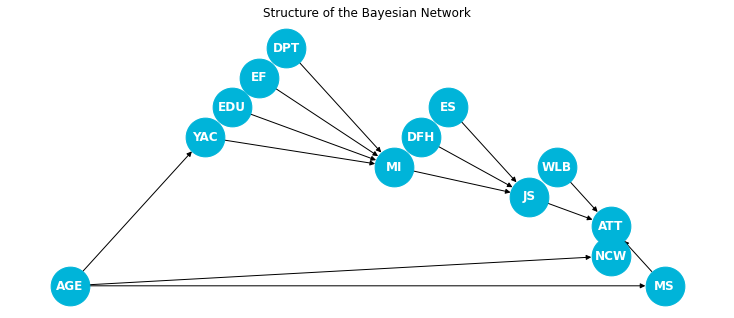

In [ ]:
#Bayesian Network graphical plot
plt.figure(figsize=(10, 4))
nx.draw(nodes, pos=nx.planar_layout(nodes), node_color='#00b4d9', node_size=1500, with_labels=True, font_color='w', font_weight='bold')
plt.title('Structure of the Bayesian Network')
plt.show()

# **3. Inference**

This Bayesian Network is constructed to determine which are the most relevant causes that lead an employee to attition. In order to do this, two kind of inference have been used:


*   Exact Inference: in particular, Variable Elimination;
*   Approximate Inference: in paricular, Likelihood Weighted Sampling.



**3.1 Exact Inference**

Firstly, Exact Inference is used.
To determine which variable affects the most the attrition, all the variables must be considered alone as evidence, using all the values that they can take, and "Attrition" as the query variable.

In [ ]:
inference_ve = VariableElimination(model)

In [ ]:
variables = list(data) #all the dataset variables into a list
variables.remove("Attrition") #Attrition is removed from variables list

causes_attrition = {} #dictionary

for variable in variables: #for each variable in variables
  for variable_value in sorted(data[variable].unique()): #for each variable value
      q = inference_ve.query(variables=["Attrition"], evidence={variable : variable_value}) #Attrition taken as query variable, given 'variable' and its value as evidence
      #save as value of dictionary the biggest probability of attrition and its value
      if causes_attrition.get(variable):  #if a value already exists, 
        if q.values[0] > causes_attrition[variable][0]: #compare if the current value is bigger than the one saved
          causes_attrition[variable] = [q.values[0], variable_value]  #save the current value 
      else:  #if no value already exists
        causes_attrition[variable] = [q.values[0], variable_value]  #save the current value

causes_attrition = dict(sorted(causes_attrition.items(), key=lambda x:x[1], reverse=True)) #dictionary sorting
causes_attrition

{'WorkLifeBalance': [0.2893415655079567, 1],
 'MaritalStatus': [0.2554355044181135, 1],
 'JobSatisfaction': [0.23355882659607066, 1],
 'NumCompaniesWorked': [0.19804300926225943, 3],
 'Age': [0.18869024857579433, 1],
 'DistanceFromHome': [0.16696186816454775, 3],
 'MonthlyIncome': [0.15885527466696087, 4],
 'YearsAtCompany': [0.15878629184110474, 1],
 'EnvironmentSatisfaction': [0.15870031211569716, 3],
 'Department': [0.1578756959940392, 3],
 'Education': [0.15787565740892076, 5],
 'EducationField': [0.15787017520745403, 5]}

The results obtained show that the three attributes that have the most influence on employee attrition are WorkLifeBalance, MaritalStatus and JobSatisfaction. Moreover, it is to be noted that the variables WorkLifeBalance and JobSatisfaction assume the lowest value in their relative range of values, meaning that a poor work life balance and a low job satisfaction lead to a higher attrition probability, and the MartitalStatus has value 1, which means that when the employee is not in a sentimental reationship, it is more likely that he/she will quit the job.

In [ ]:
variables = list(data) #all the dataset variables into a list
variables.remove("Attrition") #Attrition is removed from variables list beacause it's useless

causes_no_attrition = {}

for variable in variables: #for each variable in variables
  for variable_value in sorted(data[variable].unique()): #for each variable value
      q = inference_ve.query(variables=["Attrition"], evidence={variable : variable_value}) #Attrition query given variable and its value as evidence
      #save as value of dictionary the biggest probability of not attrition and its value
      if causes_no_attrition.get(variable):
        if q.values[1] > causes_no_attrition[variable][0]:
          causes_no_attrition[variable] = [q.values[1], variable_value]
      else:  
        causes_no_attrition[variable] = [q.values[1], variable_value]

causes_no_attrition = sorted(causes_no_attrition.items(), key=lambda x:x[1], reverse=True) #dictionary sorting
causes_no_attrition

[('MaritalStatus', [0.9035173917488998, 3]),
 ('JobSatisfaction', [0.8954756379526192, 4]),
 ('WorkLifeBalance', [0.8603972742361692, 3]),
 ('NumCompaniesWorked', [0.856900137668281, 2]),
 ('Age', [0.8501299036167518, 4]),
 ('DistanceFromHome', [0.8489023410728581, 4]),
 ('YearsAtCompany', [0.8474029446403968, 3]),
 ('MonthlyIncome', [0.8469594312059777, 1]),
 ('EnvironmentSatisfaction', [0.8431755486774041, 2]),
 ('EducationField', [0.8425037340094964, 6]),
 ('Department', [0.8423983699134776, 1]),
 ('Education', [0.8423960004970307, 2])]

On the other side, it is possible to see that the three most influential variables considered before are also the ones that influence the most the case in which the employee doesn't leave the job, obviously considering different values.

Proceeding with the analysis, exploiting Evidential Reasoning, it's possible to query Age and Education given Attrition = Yes.

In [ ]:
query = inference_ve.query(variables=["Age"], evidence={"Attrition": 1})
print(query)

+--------+------------+
| Age    |   phi(Age) |
+========+============+
| Age(1) |     0.1001 |
+--------+------------+
| Age(2) |     0.2682 |
+--------+------------+
| Age(3) |     0.2907 |
+--------+------------+
| Age(4) |     0.1822 |
+--------+------------+
| Age(5) |     0.1004 |
+--------+------------+
| Age(6) |     0.0584 |
+--------+------------+


In [ ]:
query = inference_ve.query(variables=["Education"], evidence={"Attrition": 1})
print(query)

+--------------+------------------+
| Education    |   phi(Education) |
+==============+==================+
| Education(1) |           0.1156 |
+--------------+------------------+
| Education(2) |           0.1917 |
+--------------+------------------+
| Education(3) |           0.3893 |
+--------------+------------------+
| Education(4) |           0.2708 |
+--------------+------------------+
| Education(5) |           0.0327 |
+--------------+------------------+


Intercausal Reasoning is now studied, considering MonthlyIncome as query variable and Age as evidence.

In [ ]:
unique = sorted(data["Age"].unique())

for value in unique:
  query = inference_ve.query(variables=["MonthlyIncome"], evidence={"Age": value})
  print("Age:",value,"\n",query)

Age: 1 
 +------------------+----------------------+
| MonthlyIncome    |   phi(MonthlyIncome) |
+==================+======================+
| MonthlyIncome(1) |               0.0449 |
+------------------+----------------------+
| MonthlyIncome(2) |               0.3911 |
+------------------+----------------------+
| MonthlyIncome(3) |               0.3578 |
+------------------+----------------------+
| MonthlyIncome(4) |               0.1470 |
+------------------+----------------------+
| MonthlyIncome(5) |               0.0592 |
+------------------+----------------------+
Age: 2 
 +------------------+----------------------+
| MonthlyIncome    |   phi(MonthlyIncome) |
+==================+======================+
| MonthlyIncome(1) |               0.0420 |
+------------------+----------------------+
| MonthlyIncome(2) |               0.3492 |
+------------------+----------------------+
| MonthlyIncome(3) |               0.3691 |
+------------------+----------------------+
| MonthlyIncom

**3.2 Approximate Inference**

The same analysis can be done using Approximate Inference.

In [ ]:
inference_bms = BayesianModelSampling(model)

In [ ]:
def likelihood_weighting(Q,evidence,n):
  samples = inference_bms.likelihood_weighted_sample(evidence=evidence, size=n, seed=0, show_progress=False)

  unique = samples[Q].unique()
  unique.sort()
      
  prob_lst = []

  for val in unique:
      rows = samples[samples[Q] == val]
          
      numerator = np.sum(rows['_weight'])
      denominator = np.sum(samples['_weight'])
      prob = round(numerator/denominator, 6)
          
      prob_lst.append(prob)
  
  return prob_lst


In [ ]:
variables = list(data) #all the dataset variables into a list
variables.remove("Attrition") #Attrition is removed from variables list beacause it's useless

causes_attrition = {}

for variable in variables: #for each variable in variables
  for variable_value in sorted(data[variable].unique()): #for each variable value
      q = likelihood_weighting("Attrition", [State(variable, variable_value)], 10000)
      #save as value of dictionary the biggest probability of attrition and its value
      if causes_attrition.get(variable):
        if q[0] > causes_attrition[variable][0]:
          causes_attrition[variable] = [q[0], variable_value]
      else:  
        causes_attrition[variable] = [q[0], variable_value]

causes_attrition = sorted(causes_attrition.items(), key=lambda x:x[1], reverse=True) #dictionary sorting
causes_attrition

/usr/local/lib/python3.8/dist-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(


[('WorkLifeBalance', [0.2741, 1]),
 ('NumCompaniesWorked', [0.268735, 3]),
 ('MaritalStatus', [0.251787, 1]),
 ('JobSatisfaction', [0.236328, 2]),
 ('Age', [0.2015, 6]),
 ('YearsAtCompany', [0.191589, 3]),
 ('DistanceFromHome', [0.1888, 3]),
 ('MonthlyIncome', [0.188479, 4]),
 ('EducationField', [0.1862, 2]),
 ('EnvironmentSatisfaction', [0.1858, 2]),
 ('Education', [0.1857, 5]),
 ('Department', [0.1844, 1])]

In [ ]:
variables = list(data) #all the dataset variables into a list
variables.remove("Attrition") #Attrition is removed from variables list beacause it's useless

causes_no_attrition = {}

for variable in variables: #for each variable in variables
  for variable_value in sorted(data[variable].unique()): #for each variable value
      q = likelihood_weighting("Attrition", [State(variable, variable_value)], 10000)
      #save as value of dictionary the biggest probability of attrition and its value
      if causes_no_attrition.get(variable):
        if q[1] > causes_no_attrition[variable][0]:
          causes_no_attrition[variable] = [q[1], variable_value]
      else:  
        causes_no_attrition[variable] = [q[1], variable_value]

causes_no_attrition = sorted(causes_no_attrition.items(), key=lambda x:x[1], reverse=True) #dictionary sorting
causes_no_attrition

[('MaritalStatus', [0.909876, 3]),
 ('JobSatisfaction', [0.847364, 4]),
 ('NumCompaniesWorked', [0.834865, 1]),
 ('WorkLifeBalance', [0.8315, 3]),
 ('YearsAtCompany', [0.825043, 4]),
 ('Age', [0.8225, 3]),
 ('MonthlyIncome', [0.82001, 1]),
 ('DistanceFromHome', [0.8197, 4]),
 ('Department', [0.8189, 3]),
 ('Education', [0.8171, 2]),
 ('EducationField', [0.8163, 5]),
 ('EnvironmentSatisfaction', [0.8151, 4])]